In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ccdata/CC GENERAL.csv


In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# Project overview

The goal of this Kaggle project is to segment credit card customers into meaningful groups using unsupervised learning techniques on the dataset from Kaggle: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data. By clustering customers based on their credit card usage patterns, we aim to uncover distinct behavioral segments to inform targeted **marketing strategies, risk management, and product development** for a credit card company.

# Dataset explanation
Taken from the dataset data.
This is a sample Dataset summarizes the usage behavior of about 9000 active credit card holders. The file is at a customer level with 18 behavioral variables

1. CUST_ID : Identification of Credit Card holder (Categorical)
2. BALANCE : Balance amount left in their account to make purchases.
3. BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and     1 (1 = frequently updated, 0 = not frequently updated).
4. PURCHASES : Amount of purchases made from account.
5. ONEOFF_PURCHASES : Maximum purchase amount done in one-go.
6. INSTALLMENTS_PURCHASES : Amount of purchase done in installment.
7. CASH_ADVANCE : Cash in advance given by the user.
8. PURCHASES_FREQUENCY : How frequently the Purchases are being made, score        between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased).
9. ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1     = frequently purchased, 0 = not frequently purchased).
10. PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are      being done (1 = frequently done, 0 = not frequently done).
11. CASHADVANCEFREQUENCY : How frequently the cash in advance being paid.
12. CASHADVANCETRX : Number of Transactions made with "Cash in Advanced".
13. PURCHASES_TRX : Numbe of purchase transactions made.
14. CREDIT_LIMIT : Limit of Credit Card for user.
15. PAYMENTS : Amount of Payment done by user.
16. MINIMUM_PAYMENTS : Minimum amount of payments made by user.
17. PRCFULLPAYMENT : Percent of full payment paid by user.
18. TENURE : Tenure of credit card service for user.

In [63]:
df = pd.read_csv('/kaggle/input/ccdata/CC GENERAL.csv')

In [64]:
print(df.head())

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000       

In [65]:
print("\nShape:", df.shape)


Shape: (8950, 18)


In [66]:
print("\nColumns:", df.columns.tolist())


Columns: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [67]:
print("\nData Types:\n", df.dtypes)


Data Types:
 CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object


# EDA

1. Understand Feature Distributions.
2. Detect Missing Values and Anomalies: Identify missing data, inconsistencies, or outliers that could impact clustering quality.
3. Explore Feature Relationships: Analyze correlations and interactions between features to uncover patterns.
4. Support Clustering: Identify key features (e.g., BALANCE, PURCHASES, CASH_ADVANCE) that drive customer segmentation.

In [68]:
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
             BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.00

In [69]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


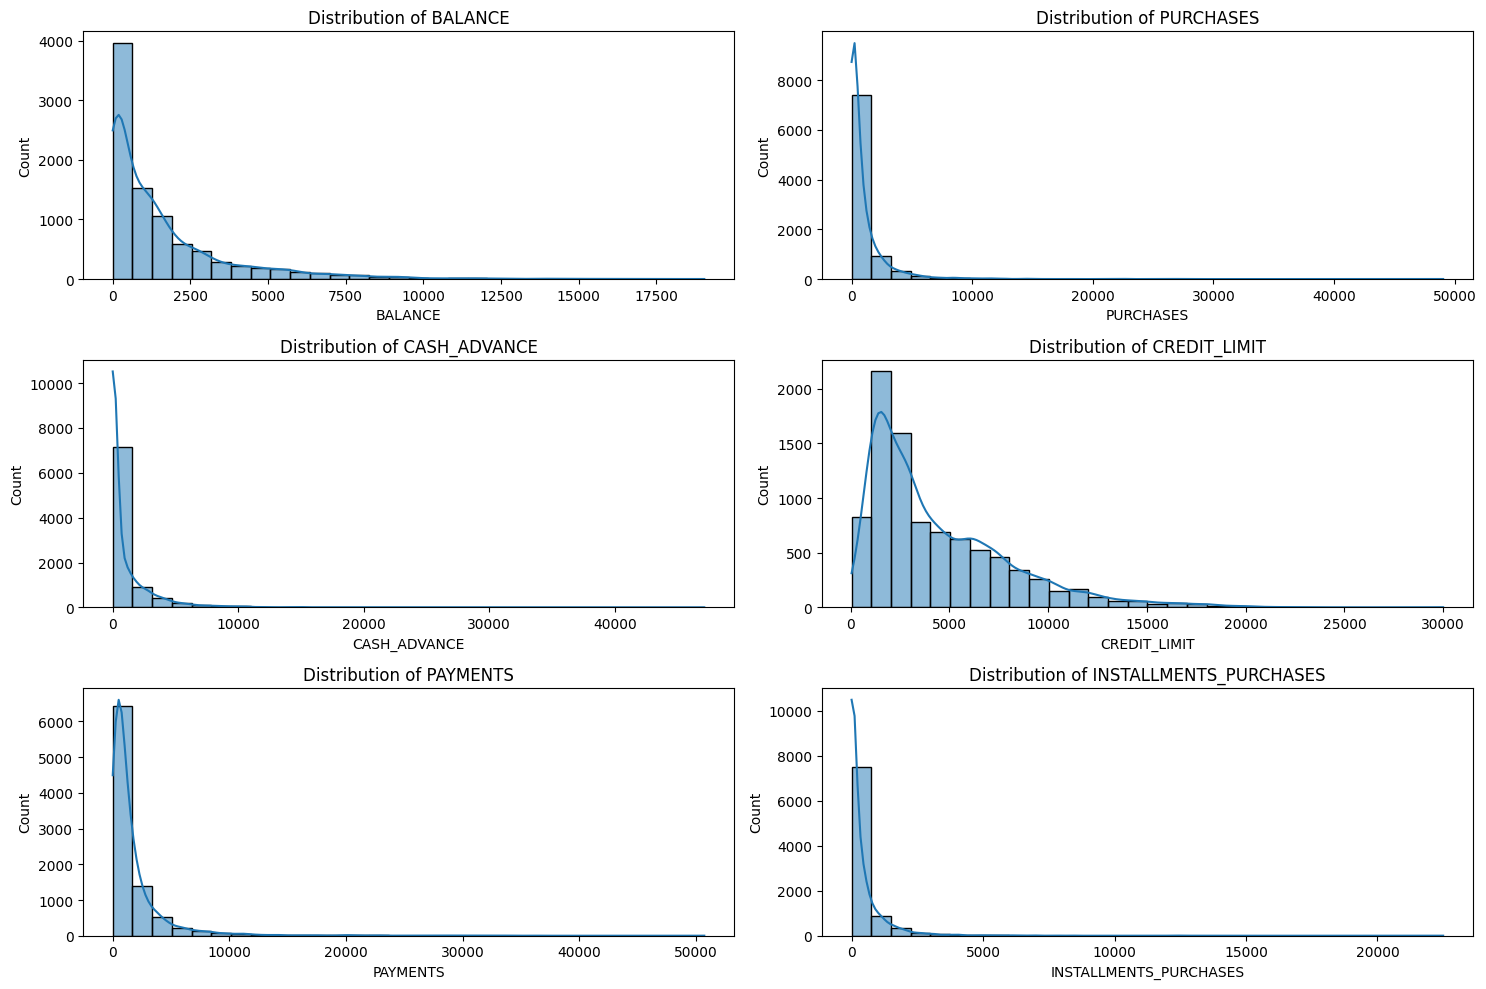

In [70]:
# a. Distribution of Key Numerical Features
key_features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS','INSTALLMENTS_PURCHASES']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

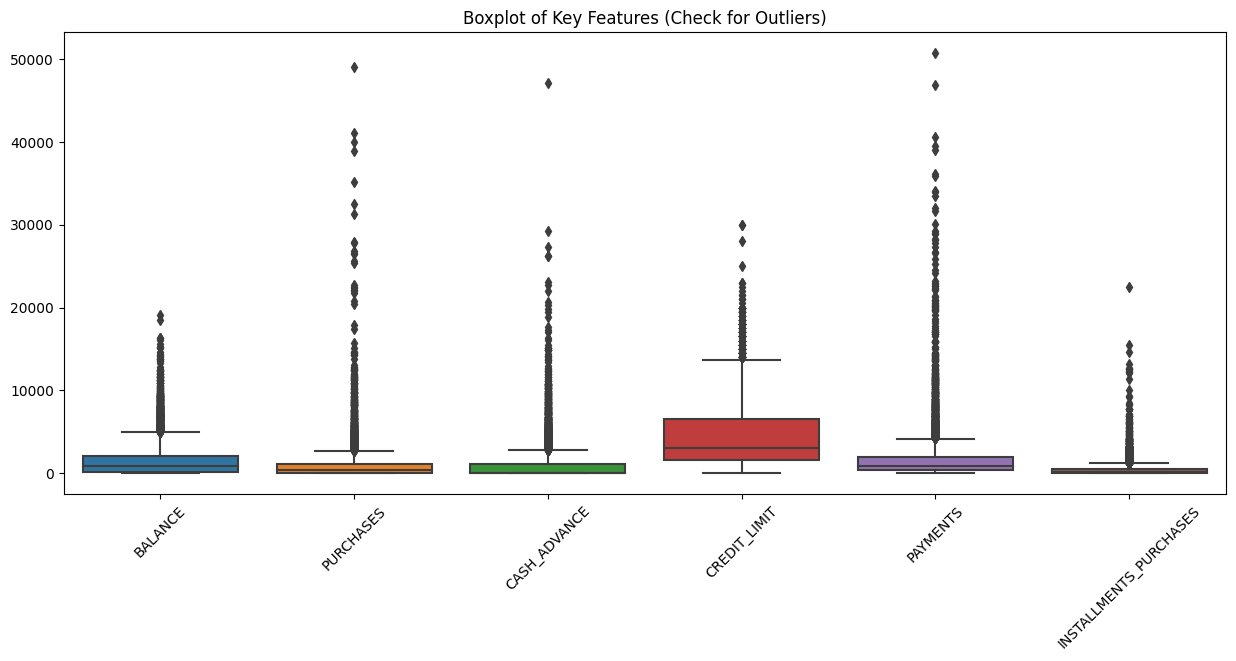

In [71]:
# b. Boxplot to Detect Outliers
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[key_features])
plt.title('Boxplot of Key Features (Check for Outliers)')
plt.xticks(rotation=45)
plt.show()

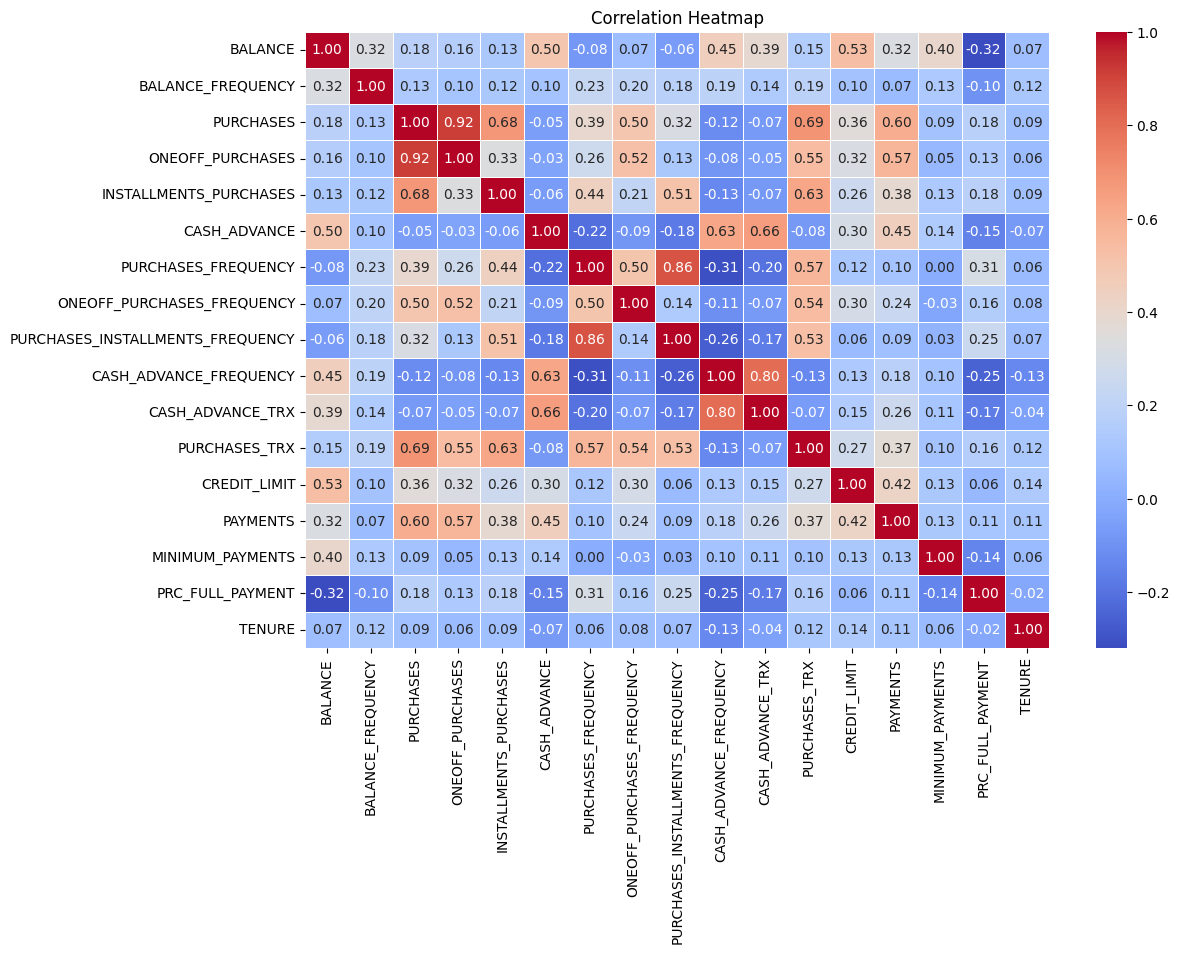

In [72]:
# d. Correlation Heatmap
plt.figure(figsize=(12, 8))
# Drop non-numeric column 'CUST_ID' for correlation
corr = df.drop('CUST_ID', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

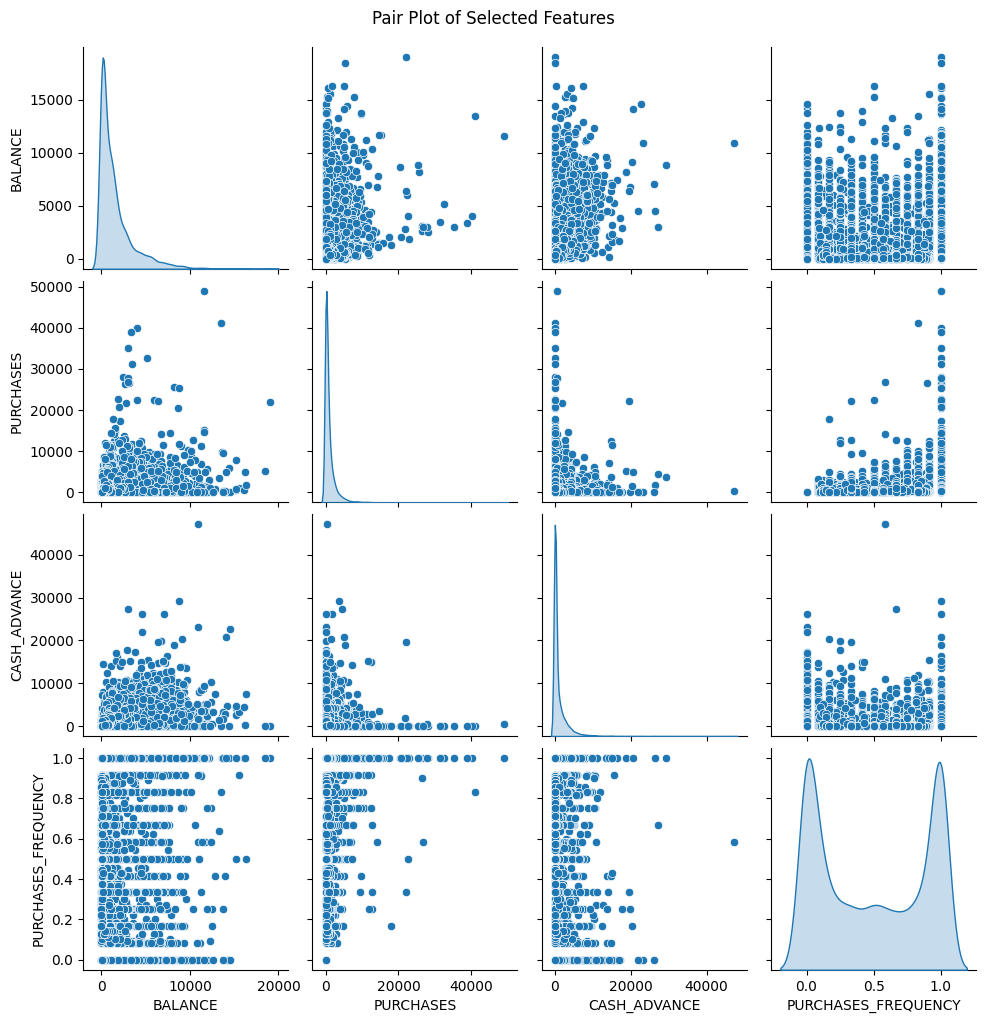

In [73]:
#e. Pair Plot for Selected Features (subset to avoid clutter)
subset_features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY']
sns.pairplot(df[subset_features], diag_kind='kde')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

In [74]:
# Percentage of customers with full payment
print("\nPercentage of Customers with Full Payment (PRC_FULL_PAYMENT > 0):")
print(f"{(df['PRC_FULL_PAYMENT'] > 0).mean() * 100:.2f}%")


Percentage of Customers with Full Payment (PRC_FULL_PAYMENT > 0):
34.04%


# EDA findings & summary
1.  Dataset Structure: The dataset is well-structured for unsupervised learning, with minimal preprocessing needed for missing values. Dropping CUST_ID was necessary as it’s non-informative for clustering. We see some missing values in minimum payments & credit limit.
2. Feature Distributions: Most features are right-skewed, indicating a majority of customers with low values and a few with extreme values.
3. Feature Correlations: High positive correlations (0.7–0.9) between PURCHASES, ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES, PURCHASES_TRX, and PURCHASES_FREQUENCY. Features like TENURE and PRC_FULL_PAYMENT showed weak correlations (<0.3) with most others, suggesting independent behaviors.
4. Customer Behavior Patterns: A scatter plot of CASH_ADVANCE vs. PRC_FULL_PAYMENT showed that high cash advance users typically have low full payment rates, indicating risky financial behavior.

# Data preprocessing
1. We are handling the missing values with the median of the column
2. We are dropping cust_id as it doesn't have any implication to find & segregate the groups.
3. Feature scaling to normalize the data.
4. We will be reducing the dimensionality as well as noise with PCA.

In [75]:
# Handle missing values
# Impute CREDIT_LIMIT with median
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median(), inplace=True)

# Impute MINIMUM_PAYMENTS with median
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

# Verify no missing values remain
print("\nMissing values after preprocessing:")
print(df.isnull().sum())


Missing values after preprocessing:
CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


In [76]:
# Customer id isn't useful data metric, so dropping it out.
df = df.drop(columns=['CUST_ID'])

In [77]:
# Feature scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.shape

(8950, 17)

In [78]:
# Dimensionality reduction with PCA
# Retain 95% of variance
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)
print(f"Number of PCA components: {df_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Number of PCA components: 12
Explained variance ratio: 0.9608


In [79]:
df_pca

array([[-1.68364879e+00, -1.07224148e+00,  4.75660084e-01, ...,
        -7.81956004e-02, -2.35948299e-01, -5.24972248e-02],
       [-1.13408493e+00,  2.50914981e+00,  6.02216308e-01, ...,
        -7.77929470e-01, -8.70746073e-01, -6.07171068e-01],
       [ 9.69394988e-01, -3.83576903e-01,  9.09697616e-02, ...,
        -1.74404835e-03, -7.62170193e-01,  6.83869942e-01],
       ...,
       [-9.28985122e-01, -1.80804835e+00, -4.58242377e-01, ...,
        -8.30135631e-01,  1.20175848e-01,  7.31414169e-02],
       [-2.33784475e+00, -6.53611332e-01,  9.82831153e-01, ...,
         2.68662638e-01, -3.06599164e-01, -1.13268706e-01],
       [-5.58026533e-01, -4.00646098e-01,  1.03364560e+00, ...,
         3.46160674e-01, -5.05323873e-01,  1.22672594e-01]])

# Model Building(k-means Clustering)

In [80]:
inertia = []
silhouette_scores = []
K = range(2, 11)  # Test k from 2 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)  # Use PCA-transformed data
    inertia.append(kmeans.inertia_)
    if k > 1:  # Silhouette score requires at least 2 clusters
        score = silhouette_score(df_pca, kmeans.labels_)
        silhouette_scores.append(score)

silhouette_scores

[0.2183202351129336,
 0.2535392832593576,
 0.20788441990781675,
 0.20463751401500763,
 0.21478705225166467,
 0.2223784204214999,
 0.23437823744278755,
 0.22742271753983168,
 0.2341730872448205]

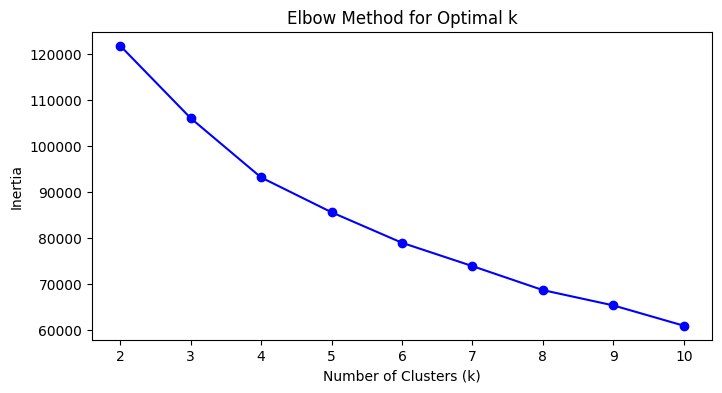

In [81]:
# Plot Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

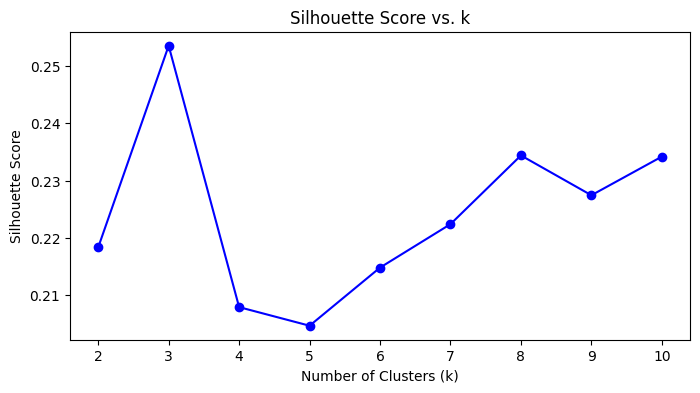

In [82]:
# Plot Silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.show()

In [83]:
# Fit K-means with optimal k & more clusters (Choosing k=8 for being the balance between the optiomal k & higher cluster segmentation)
optimal_k = 8 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_pca)

In [84]:
df_pca[0]

array([-1.68364879, -1.07224148,  0.47566008,  0.67992776,  0.04319508,
        0.06806942,  0.82215526, -0.01895178,  0.11833594, -0.0781956 ,
       -0.2359483 , -0.05249722])

In [85]:
# Analyze clusters
print("Cluster sizes:\n", df['Cluster'].value_counts())

Cluster sizes:
 Cluster
0    2770
1    1999
5    1188
2    1132
3     880
7     624
4     333
6      24
Name: count, dtype: int64


# Visualizing the cluster

In [86]:
# Summary statistics for each cluster
cluster_summary = df.groupby('Cluster').mean()
print("Cluster means:\n", cluster_summary)

Cluster means:
              BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                   
0        1588.998141           0.973272    246.712697        196.283682   
1         815.984375           0.956238    925.719025        186.735913   
2        1304.151656           0.972996   2211.265645       1727.998392   
3        5033.561142           0.969784    530.949932        330.692341   
4        3811.614540           0.987142   6520.381532       3671.135916   
5         105.559197           0.371530    340.666490        202.948350   
6        5405.330935           0.957955  27276.363750      21877.102917   
7         864.004329           0.795129    390.635481        239.709567   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                     50.607671    772.026075             0.152834   
1                    73

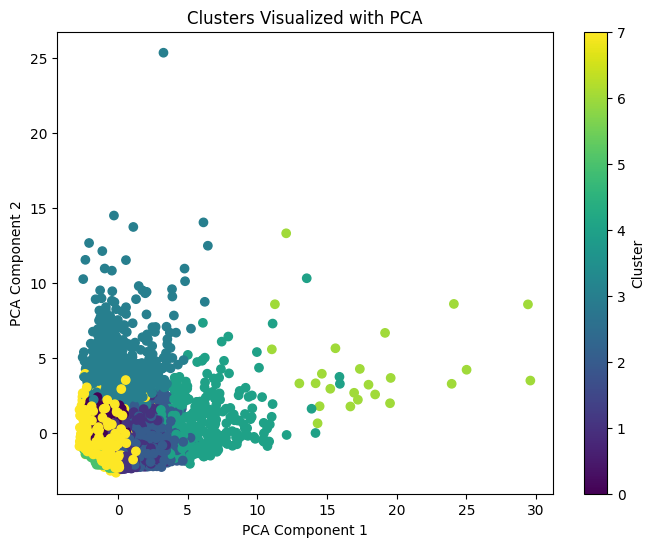

In [87]:
# Visualize clusters (using first two PCA components)
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualized with PCA')
plt.colorbar(label='Cluster')
plt.show()

# Interpreting the cluster

In [88]:
# Key features to focus on
key_features = [
    'BALANCE', 'PURCHASES', 'CASH_ADVANCE', 
    'PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'CREDIT_LIMIT'
]

# Function to interpret clusters with relative comparisons
def interpret_clusters_relative(summary, features):
    descriptions = {}
    # Rank clusters for each feature (highest to lowest)
    rankings = {}
    for feature in features:
        rankings[feature] = summary[feature].sort_values(ascending=False).index.tolist()
    
    # Print rankings for reference
    print("\nCluster Rankings (Highest to Lowest):")
    for feature, rank in rankings.items():
        print(f"{feature}: {rank}")
    
    # Describe each cluster
    for cluster in summary.index:
        characteristics = []
        row = summary.loc[cluster]
        
        # Compare to other clusters
        for feature in features:
            value = row[feature]
            rank = rankings[feature].index(cluster)
            total_clusters = len(summary)
            
            # Highlight if cluster is highest or lowest
            if rank == 0:
                characteristics.append(f"Highest {feature} ({value:.2f})")
            elif rank == total_clusters - 1:
                characteristics.append(f"Lowest {feature} ({value:.2f})")
            else:
                # Note if value is notably high or low (e.g., top 2 or bottom 2)
                if rank < 2:
                    characteristics.append(f"Very high {feature} ({value:.2f}, #{rank+1})")
                elif rank > total_clusters - 3:
                    characteristics.append(f"Very low {feature} ({value:.2f}, #{rank+1})")
                else:
                    characteristics.append(f"Moderate {feature} ({value:.2f})")
        
        # Add tenure if it stands out (e.g., Cluster 7 has low tenure)
        if 'TENURE' in summary.columns:
            tenure = row['TENURE']
            tenure_rank = summary['TENURE'].sort_values(ascending=False).index.tolist().index(cluster)
            if tenure_rank == 0:
                characteristics.append(f"Highest tenure ({tenure:.2f})")
            elif tenure_rank == len(summary) - 1:
                characteristics.append(f"Lowest tenure ({tenure:.2f})")
        
        descriptions[cluster] = "; ".join(characteristics)
    
    return descriptions

# Apply interpretation
cluster_descriptions = interpret_clusters_relative(cluster_summary, key_features)

# Print results
print("\nCluster Interpretations (Relative to Other Clusters):")
for cluster, desc in cluster_descriptions.items():
    print(f"Cluster {cluster}: {desc}")


Cluster Rankings (Highest to Lowest):
BALANCE: [6, 3, 4, 0, 2, 7, 1, 5]
PURCHASES: [6, 4, 2, 1, 3, 7, 5, 0]
CASH_ADVANCE: [3, 6, 7, 0, 4, 5, 2, 1]
PURCHASES_FREQUENCY: [4, 6, 2, 1, 7, 3, 5, 0]
PRC_FULL_PAYMENT: [6, 2, 1, 5, 4, 7, 3, 0]
CREDIT_LIMIT: [6, 4, 3, 2, 5, 1, 0, 7]

Cluster Interpretations (Relative to Other Clusters):
Cluster 0: Moderate BALANCE (1589.00); Lowest PURCHASES (246.71); Moderate CASH_ADVANCE (772.03); Lowest PURCHASES_FREQUENCY (0.15); Lowest PRC_FULL_PAYMENT (0.02); Very low CREDIT_LIMIT (3380.85, #7)
Cluster 1: Very low BALANCE (815.98, #7); Moderate PURCHASES (925.72); Lowest CASH_ADVANCE (217.29); Moderate PURCHASES_FREQUENCY (0.89); Moderate PRC_FULL_PAYMENT (0.25); Moderate CREDIT_LIMIT (3520.65)
Cluster 2: Moderate BALANCE (1304.15); Moderate PURCHASES (2211.27); Very low CASH_ADVANCE (283.85, #7); Moderate PURCHASES_FREQUENCY (0.89); Very high PRC_FULL_PAYMENT (0.29, #2); Moderate CREDIT_LIMIT (6210.76)
Cluster 3: Very high BALANCE (5033.56, #2); Moderat

# Results, analysis & evaluation of consumer clusters of Model 1

**Cluster 0**: Inactive Users

Characteristics: Moderate balance (1589.00), lowest purchases (246.71), lowest purchase frequency (0.15), lowest full payment rate (0.02), very low credit limit (3380.85), highest tenure (11.88).

Profile: Long-term customers with minimal activity, low spending, and poor payment habits. Likely low-value or dormant accounts.

Business Implication: Target with reactivation campaigns (e.g., promotional offers) or consider reducing credit limits to mitigate risk.

**Cluster 1**: Frugal Frequent Shoppers

Characteristics: Very low balance (815.98, #7), moderate purchases (925.72), lowest cash advance (217.29), high purchase frequency (0.89), high full payment rate (0.25), moderate credit limit (3520.65).

Profile: Low-balance customers who shop frequently but conservatively, with good payment discipline.

Business Implication: Offer rewards for frequent purchases or increase credit limits to encourage higher spending.

**Cluster 2**: Active Moderate Spenders

Characteristics: Moderate balance (1304.15), moderate purchases (2211.27), very low cash advance (283.85, #7), high purchase frequency (0.89), very very high full payment rate (0.29), moderate credit limit (6210.76), highest tenure (11.88).

Profile: Active customers with moderate spending, frequent purchases, and strong payment habits.

Business Implication: Target with loyalty programs or premium card offers to retain and upsell.

**Cluster 3**: High-Risk Cash Advance Users

Characteristics: Very high balance (5033.56, #2), moderate purchases (530.95), highest cash advance (5169.32), low purchase frequency (0.30), very low full payment rate (0.04, #7), high credit limit (8193.19).

Profile: High-balance customers relying heavily on cash advances, with low spending and poor payment habits.

Business Implication: Monitor for credit risk; consider reducing credit limits or offering financial counseling.

**Cluster 4**: High-Spending Active Users

Characteristics: Moderate balance (3811.61), very high purchases (6520.38, #2), moderate cash advance (662.16), highest purchase frequency (0.96), moderate full payment rate (0.23), very high credit limit (9275.23), highest tenure (11.97).

Profile: Active, high-spending customers with frequent purchases and strong credit profiles.

Business Implication: Target with exclusive offers or higher-tier cards to maximize revenue.

**Cluster 5**: Dormant Low-Balance Users

Characteristics: Lowest balance (105.56), very low purchases (340.67, #7), moderate cash advance (303.11), very low purchase frequency (0.27, #7), moderate full payment rate (0.24), moderate credit limit (3857.19).

Profile: Minimal activity customers with low balances and good payment habits.

Business Implication: Low priority; consider minimal engagement or account closure to reduce maintenance costs.

**Cluster 6**: Elite Spenders

Characteristics: Highest balance (5405.33), highest purchases (27276.36), very high cash advance (1550.38, #2), very high purchase frequency (0.91), highest full payment rate (0.51), highest credit limit (16083.33).

Profile: High-value customers with extremely high spending, frequent purchases, and excellent payment habits.

Business Implication: Prioritize with VIP services, exclusive rewards, or premium card upgrades.

**Cluster 7**: New Low-Activity Users

Characteristics: Moderate balance (864.00), moderate purchases (390.64), moderate cash advance (1121.64), moderate purchase frequency (0.41), moderate full payment rate (0.16), lowest credit limit (2441.54), lowest tenure (7.23).

Profile: Newer customers with low activity, moderate cash advance usage, and limited credit.

Business Implication: Engage with onboarding campaigns to increase activity or assess for potential churn.

# Tuning hyperparameters

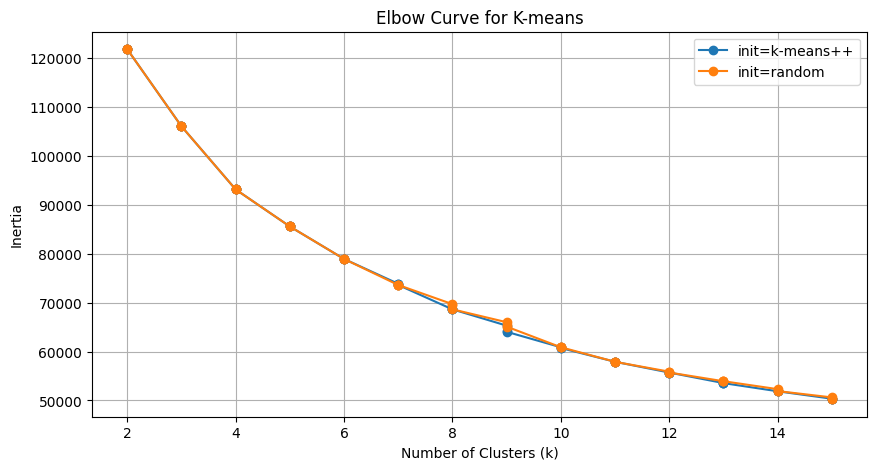

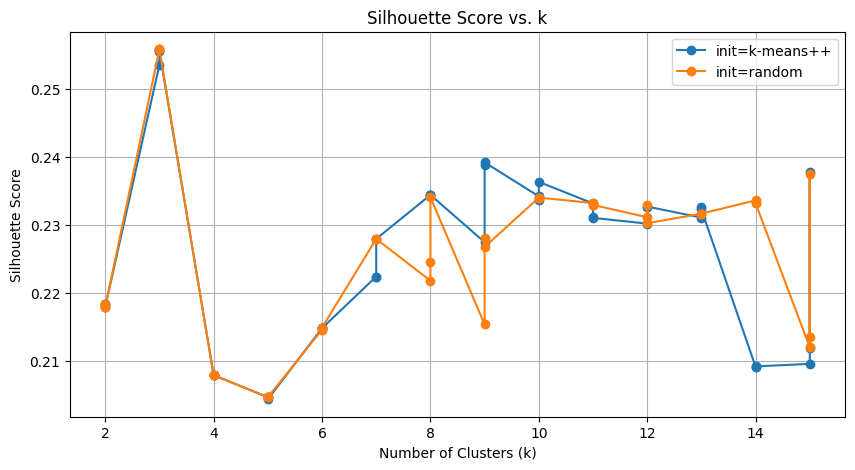

Best Configuration:
k: 3, init: random, n_init: 10
Silhouette Score: 0.2558
Inertia: 106057.1059
Davies-Bouldin: 1.5399
Calinski-Harabasz: 1692.3503

New Cluster Summary:
              BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0         806.543797           0.834958   498.666256        248.000976   
1        2189.128870           0.981367  4223.400605       2693.869928   
2        4028.493534           0.959265   392.426916        253.268193   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                    250.985659    337.787699             0.461811   
1                   1530.008003    448.118280             0.947765   
2                    139.237695   3913.145945             0.234855   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                          

In [89]:
# Define hyperparameter grid
k_range = range(2, 16)  # Test k from 2 to 15
init_methods = ['k-means++', 'random']
n_init_values = [10, 20, 50]

# Store results
results = []

# Perform grid search
for k in k_range:
    for init in init_methods:
        for n_init in n_init_values:
            # Fit K-means
            kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, max_iter=300, random_state=42)
            labels = kmeans.fit_predict(df_pca)
            
            # Compute metrics
            inertia = kmeans.inertia_
            silhouette = silhouette_score(df_pca, labels) if k > 1 else np.nan
            davies_bouldin = davies_bouldin_score(df_pca, labels) if k > 1 else np.nan
            calinski_harabasz = calinski_harabasz_score(df_pca, labels) if k > 1 else np.nan
            
            # Store results
            results.append({
                'k': k,
                'init': init,
                'n_init': n_init,
                'inertia': inertia,
                'silhouette': silhouette,
                'davies_bouldin': davies_bouldin,
                'calinski_harabasz': calinski_harabasz
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot Elbow curve (Inertia vs. k)
plt.figure(figsize=(10, 5))
for init in init_methods:
    subset = results_df[results_df['init'] == init]
    plt.plot(subset['k'], subset['inertia'], marker='o', label=f'init={init}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means')
plt.legend()
plt.grid(True)
plt.show()

# Plot Silhouette Score vs. k
plt.figure(figsize=(10, 5))
for init in init_methods:
    subset = results_df[results_df['init'] == init]
    plt.plot(subset['k'], subset['silhouette'], marker='o', label=f'init={init}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.legend()
plt.grid(True)
plt.show()

# Find best configuration
best_result = results_df.loc[results_df['silhouette'].idxmax()]
print("Best Configuration:")
print(f"k: {best_result['k']}, init: {best_result['init']}, n_init: {best_result['n_init']}")
print(f"Silhouette Score: {best_result['silhouette']:.4f}")
print(f"Inertia: {best_result['inertia']:.4f}")
print(f"Davies-Bouldin: {best_result['davies_bouldin']:.4f}")
print(f"Calinski-Harabasz: {best_result['calinski_harabasz']:.4f}")

# Fit K-means with best parameters
best_kmeans = KMeans(
    n_clusters=int(best_result['k']),
    init=best_result['init'],
    n_init=int(best_result['n_init']),
    max_iter=300,
    random_state=42
)
df['Cluster'] = best_kmeans.fit_predict(df_pca)

# Summarize new clusters
new_cluster_summary = df.groupby('Cluster').mean()
print("\nNew Cluster Summary:\n", new_cluster_summary)

# Summary of cluster formation with hyperparameters
**Cluster 0**: Low-Activity, Moderate-Balance Users

Characteristics:
BALANCE: 806.54 (lowest among clusters, indicating low outstanding debt).
PURCHASES: 498.67 (lowest, with balanced one-off (248.00) and installment (250.99) purchases).
CASH_ADVANCE: 337.79 (lowest, minimal reliance on cash advances).
CREDIT_LIMIT: 3268.54 (lowest, indicating limited credit availability).

Business Implications:
Marketing: Offer incentives (e.g., cashback on purchases) to increase spending and purchase frequency.
Risk Management: Low risk due to low balances and minimal cash advances; maintain current credit limits.
Product Development: Introduce entry-level rewards cards to encourage engagement.

**Cluster 1**: High-Spending, Active Users
Characteristics:
PURCHASES: 4223.40 (highest, with significant one-off (2693.87) and installment (1530.01) purchases).
PURCHASES_FREQUENCY: 0.95 (highest, purchases in ~95% of months).
PRC_FULL_PAYMENT: 0.30 (highest, pays off balance fully 30% of the time).
CREDIT_LIMIT: 7680.55 (highest, indicating strong credit profiles).
TENURE: 11.92 (highest, suggesting long-term customers).

Business Implications:
Marketing: Target with premium card offers, travel rewards, or exclusive perks to retain high spenders.
Risk Management: Low to moderate risk due to high full payment rate; monitor balances to prevent over-leveraging.
Product Development: Develop loyalty programs or higher-tier cards with enhanced benefits.

**Cluster 2**: High-Balance, Cash Advance-Heavy Users

Characteristics:
BALANCE: 4028.49 (highest, indicating significant outstanding debt).
PURCHASES: 392.43 (lowest, with minimal one-off (253.27) and installment (139.24) purchases).
CASH_ADVANCE: 3913.15 (highest, heavy reliance on cash advances).
PURCHASES_FREQUENCY: 0.23 (lowest, purchases in ~23% of months).
PRC_FULL_PAYMENT: 0.03 (lowest, rarely pays off balance fully).

Business Implications:
Marketing: Avoid aggressive upselling; focus on debt management programs or financial education.
Risk Management: High risk due to high balances and low payment rates; consider reducing credit limits or implementing stricter repayment terms.
Product Development: Offer debt consolidation tools or low-interest balance transfer options.

# Model 2: Gaussian Mixture Model (GMM) Clustering

GMM Results (n_components=3):
Silhouette Score: 0.0804
Davies-Bouldin: 2.3446
Calinski-Harabasz: 914.2233

GMM Cluster Summary:
                  BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
GMM_Cluster                                                                  
0             460.392405           0.820778   903.960128        486.007260   
1            1738.809182           0.883304   170.529535         96.200801   
2            3053.154195           0.958304  2566.006816       1600.128655   

             INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
GMM_Cluster                                                              
0                        418.205415      0.000000             0.641872   
1                         74.565863   1321.322860             0.218043   
2                        966.361451   1982.236882             0.704432   

             ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
GMM_Cluster                     

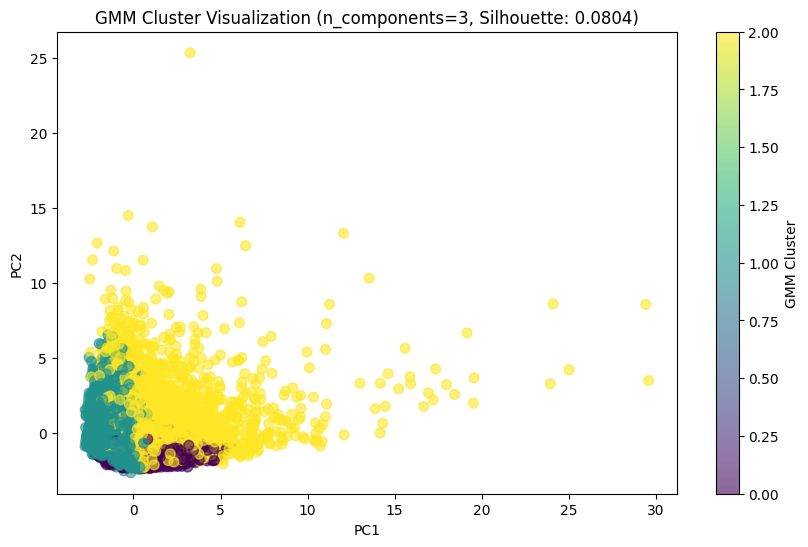

In [90]:
# Fit GMM with n_components=3
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(df_pca)

# Compute evaluation metrics
silhouette = silhouette_score(df_pca, df['GMM_Cluster'])
davies_bouldin = davies_bouldin_score(df_pca, df['GMM_Cluster'])
calinski_harabasz = calinski_harabasz_score(df_pca, df['GMM_Cluster'])

print("GMM Results (n_components=3):")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz: {calinski_harabasz:.4f}")

# Cluster summary
gmm_cluster_summary = df.groupby('GMM_Cluster').mean()
print("\nGMM Cluster Summary:\n", gmm_cluster_summary)

# Visualize clusters in PCA space
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['GMM_Cluster'], cmap='viridis', s=50, alpha=0.6)
plt.colorbar(label='GMM Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'GMM Cluster Visualization (n_components=3, Silhouette: {silhouette:.4f})')
plt.show()

# Comparison & analysis between both the models for k=3

Silhouette Score:

K-means: 0.2558 (moderate, indicating some separation but not ideal; <0.3 suggests potential overlap).
GMM: 0.0804 (very low, indicating poor separation; close to 0 suggests significant overlap or misassigned points).
Conclusion: K-means outperforms GMM significantly, as its clusters are better separated.

Davies-Bouldin Index:

K-means: 1.5399 (moderate, indicating reasonable cluster distinction).
GMM: 2.3446 (higher, suggesting less distinct clusters).
Conclusion: K-means produces clusters with better separation and less overlap than GMM.

Calinski-Harabasz Index:

K-means: 1692.3503 (higher, indicating better-defined clusters).
GMM: 914.2233 (lower, suggesting less dispersion between clusters).
Conclusion: K-means clusters are more distinct relative to their internal variance.

# Conclusion, key take aways & suggessions to improve the model clustering
Conclusion: This Kaggle project segmented credit card customers using K-means(k=8,3) and GMM(n_components=3) on the Credit Card Dataset. K-means outperformed GMM, identifying Low-Activity, High-Spending, and Cash Advance-Heavy clusters, though moderate Silhouette Scores (0.2558 vs. 0.0804) suggest room for improvement. Still Kmeans clustering is better compared to GMM based on the Silhouette Scores as this score more than 0.2 is considered as a good clustering.

Key Takeaways: With k=8, we had better clusering & more segments to use for varied marketings for each segment & have a better revenue generation for each dollar spent. K-means produced actionable segments for marketing (High-Spending), risk management (Cash Advance-Heavy), and engagement (Low-Activity). EDA revealed skewed distributions and correlations, guiding PCA and scaling. GMM’s poor performance indicates PCA or parameter limitations.

Suggestions: We could have tuned hyper parameters for GMM as well to have better & more clustering for GMM & have added more final visualizations.